#### In this question we analyze the data file **Fertility.csv** which is available in the homework folder, and try to build a model for fertility. In this dataset Fertility, the first column, is the response variable, and the other variables are potential predictors. We will use several different statistical modeling techniques. The data set contains 47 rows (samples), split the data into training and test sets. Set the first 30 rows to training samples and the rows 31 through 47 as the test samples.

In [186]:
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.linear_model as skl
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from l0bnb import fit_path
from matplotlib.pyplot import subplots

In [187]:
Data = pd.read_csv('Fertility.csv')
# print(Data)
train = (Data.index < 30)
X = MS(Data.columns.drop(['Fertility'])).fit_transform(Data)
Y = Data['Fertility']
y_train, X_train = Y.loc[train] , X.loc[train]
y_test, X_test = Y.loc[~train] , X.loc[~train]

#### (a) Fit a linear model on the training set, and report the test error (MSE) obtained.

In [188]:
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)
y_pred_linear = LinearModel.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
# print(pd.DataFrame({'y':y_test, 'pred':pred_linear}))
print('MSE Linear:', mse_linear)

MSE Linear: 183.72179150160574


#### (b) Fit a Ridge regression model on the training set, with λ chosen by cross-validation on a dense grid similar to the example solved in the class. Report the test error obtained.

In [189]:
lambdas = np.logspace(-12, 12, 100)  # Define a range of lambda values
# print(lambdas)
ridge_model = RidgeCV(alphas=lambdas, store_cv_values=True).fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print('Best lambda for Ridge:', ridge_model.alpha_)
print('MSE Ridge: ', mse_ridge)

Best lambda for Ridge: 200.92330025650458
MSE Ridge:  190.8866277059537


In [190]:
if 'intercept' in X:
    X = X.drop(columns=['intercept'], axis = 1)

Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
# print(Xs)
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
print(soln_array.shape)

(5, 100)


/var/folders/2m/48ngsqpn3qn8dwj32vc6d1hw0000gp/T/ipykernel_91070/510736322.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Xs = X - X.mean(0)[None,:]
/var/folders/2m/48ngsqpn3qn8dwj32vc6d1hw0000gp/T/ipykernel_91070/510736322.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Xs = Xs / X_scale[None,:]
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

In [191]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,Agriculture,Examination,Education,Catholic,Infant.Mortality
negative log(lambda),,,,,
-15.895617,5.392309e-07,-9.864075e-07,-0.000001,7.081504e-07,6.361744e-07
-15.663032,6.804321e-07,-1.244705e-06,-0.000001,8.935844e-07,8.027611e-07
-15.430448,8.586078e-07,-1.570639e-06,-0.000002,1.127575e-06,1.012970e-06
-15.197863,1.083440e-06,-1.981922e-06,-0.000002,1.422839e-06,1.278222e-06
-14.965279,1.367146e-06,-2.500901e-06,-0.000003,1.795419e-06,1.612934e-06
...,...,...,...,...,...
6.199897,-3.870010e+00,-2.082903e+00,-8.319523,4.311273e+00,3.141038e+00
6.432481,-3.878037e+00,-2.077882e+00,-8.330829,4.317614e+00,3.140239e+00
6.665066,-3.884416e+00,-2.073876e+00,-8.339822,4.322661e+00,3.139600e+00


#### Large $\lambda$ with small $L2$ norm

In [192]:
# print(np.argmax(lambdas), lambdas[0])
index_large_lambda = 0
beta_hat = soln_path.loc[soln_path.index[index_large_lambda]]
print(beta_hat)
print(f'lambda: {lambdas[index_large_lambda]}\nL2 norm: {np.linalg.norm(beta_hat)}')

Agriculture         5.392309e-07
Examination        -9.864075e-07
Education          -1.013754e-06
Catholic            7.081504e-07
Infant.Mortality    6.361744e-07
Name: -15.895616548341236, dtype: float64
lambda: 8005317.355936483
L2 norm: 1.7882009088901327e-06


#### Small $\lambda$ with Large $L2$ norm

In [193]:
# print(np.argmin(lambdas), lambdas[99])
index_small_lambda = 99
beta_hat = soln_path.loc[soln_path.index[index_small_lambda]]
print(beta_hat)
print(f'lambda: {lambdas[index_small_lambda]}\nL2 norm: {np.linalg.norm(beta_hat)}')

Agriculture        -3.893504
Examination        -2.068145
Education          -8.352649
Catholic            4.329864
Infant.Mortality    3.138684
Name: 7.130234381599221, dtype: float64
lambda: 0.0008005317355936483
L2 norm: 10.853681109005759


In [194]:
ridge = skl.ElasticNet(alpha=lambdas[99], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.055e+03, tolerance: 7.178e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.0008005317355936483, l1_ratio=0))])

We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [195]:
np.linalg.norm(ridge.coef_)


10.73811731525523

In [196]:
param_grid = {'ridge__alpha': lambdas}
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+03, tolerance: 6.145e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+03, tolerance: 5.830e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.08386496568159578, l1_ratio=0))])

In [197]:
best_lambda = grid.best_params_['ridge__alpha']
# print(best_lambda)
print(grid.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.08386496568159578, l1_ratio=0))])


In [198]:
print(-grid.cv_results_['mean_test_score'])

[156.87839062 156.87837727 156.87836043 156.87833918 156.87831237
 156.87827853 156.87823583 156.87818196 156.87811397 156.87802819
 156.87791994 156.87778334 156.87761098 156.87739349 156.87711904
 156.87677273 156.87633573 156.87578431 156.87508851 156.87421052
 156.87310264 156.87170469 156.86994073 156.86771494 156.86490643
 156.86136271 156.85689137 156.85124969 156.84413153 156.83515074
 156.82382036 156.80952637 156.7914947  156.76874975 156.7400623
 156.7038842  156.6582666  156.60075774 156.52827571 156.43695031
 156.32192761 156.17712977 155.99496185 155.76595767 155.47835736
 155.11761235 154.66581934 154.10109557 153.39692562 152.52153849
 151.43741509 150.10108491 148.4634441  146.47091078 144.06780518
 141.20036375 137.82270198 133.90474611 129.44158848 124.46289207
 119.04005921 113.28830744 107.36113326 101.43629825  95.69521344
  90.30034109  85.37647397  81.00058809  77.20188434  73.97023548
  71.26909382  69.04857275  67.2555087   65.83908455  64.75235877
  63.951262

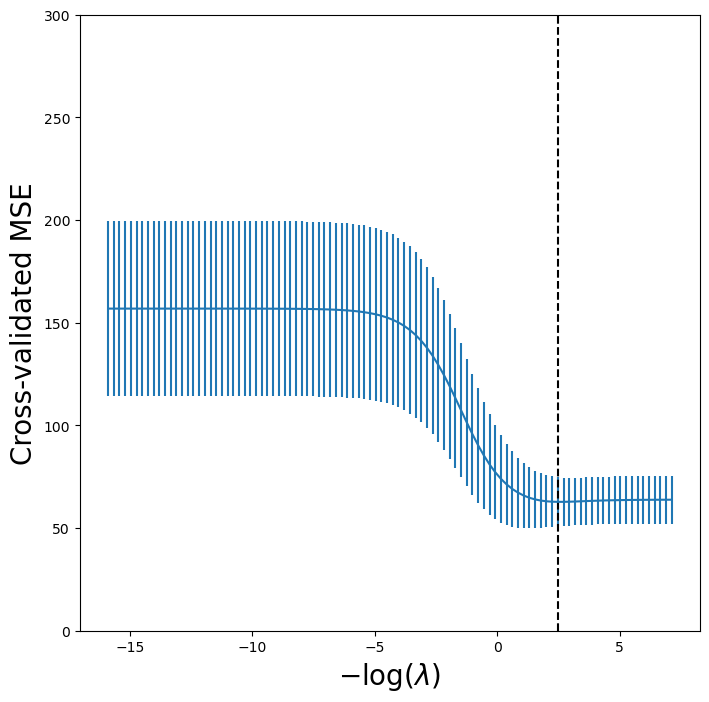

In [199]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(best_lambda), c='k', ls='--')
ax.set_ylim([0,300])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


#### (c) Fit a LASSO model on the training set, with λ chosen by cross-validation on a dense grid similar to the example solved in the class. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [200]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


0.06653839184028286

In [201]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))


In [202]:
np.min(tuned_lasso.mse_path_.mean(1))


63.772950878902805

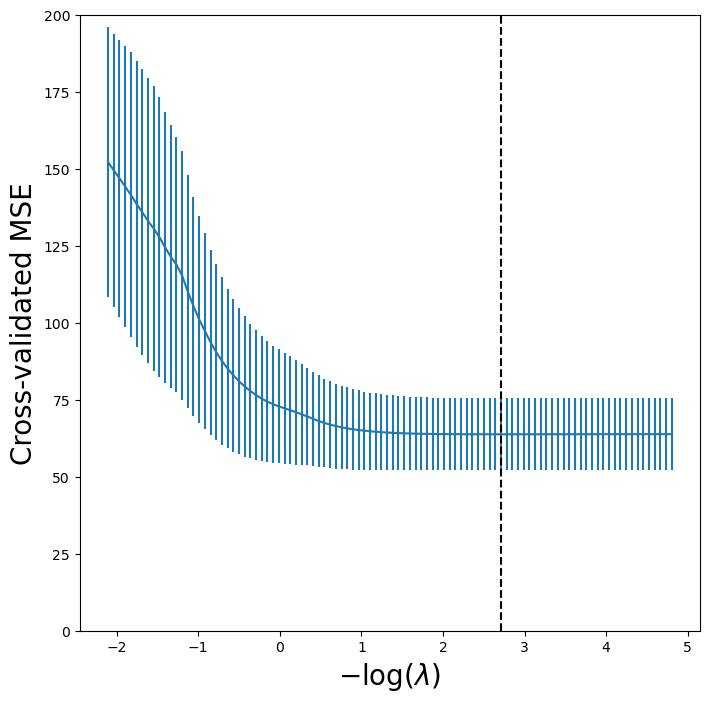

In [203]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,200])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [204]:
tuned_lasso.coef_


array([-3.60278668, -1.97026701, -8.11256291,  4.18872494,  3.0965271 ])

#### (d) Compare the results of (a), (b), and (c). Which one seems to outperform the others for this specific setup?

#### In this case, the Linear Model got the lowest MSE compared to Ridge and LASSO. The Ridge model is pretty close but got a slightly higher MSE. The LASSO has 2 non-dropped features and the highest MSE of the three models, which means that too many constraints or regularization led to underfitting.